## Discretize an Arbitrary Spectral Density 

One simple prescription (although may not be the most optimized solution) [see Walters, Allen, Makri J. Comp Chem. 10.1002/jcc.24527]. Note that here we are using the definition for $J(\omega) = \frac{\pi}{2} \sum_{i} \frac{c_i^2}{\omega_i} \delta(\omega - \omega_i)$ (and other works might use a different definition).
$$
\begin{align}
{1\over \pi}\int_{0}^{\omega_j} {J(\omega) \over \omega }d \omega =  {j-1/2\over N} \lambda 
\end{align}
$$

$$
\begin{align}
{1\over \pi}\int_{0}^{\omega_{max}} {J(\omega) \over \omega }d \omega =   \lambda 
\end{align}
$$
where $\omega_{max}$ is a maximum cutoff for the frequency. 

We define
$$
 \begin{align}
 {1\over \pi}\int_{0}^{\omega_j} {J(\omega) \over \omega }d \omega \equiv F_{\omega} (\omega_j)
 \end{align}
 $$


So $\omega_j$ is obtained by numerically solving the following equation (note $m_j = 1.0$),
  $$
  \begin{align}
  F_{\omega} (\omega_j) -  {j-1/2\over N} \lambda = 0
  \end{align} $$
  Meanwhile the $c_j$ is obtained by 
    $$ \begin{align}
  c_j =  \omega_j \sqrt{ 2{\lambda \over N} m_j  } \\
  \end{align}  $$

although here we will use $m_j = 1$

# Code to Numerically Discretize : Version 1 

Note that here we numerically integrate $J(\omega)/\omega$ to obtain $F_\omega(\omega)$. See Version 2 below where you can have an available analyitical expression for $F_\omega(\omega)$. 

In [2]:
import numpy as np
from numpy import pi as π
# N is the number of discrete mode you want
# J is the function of ω 
# ω is the range of frequencies that is used to numerically integrate.

def discretize1(N, J, ω = np.linspace(0.00001,0.1,10000)/27.2114):
    dω = ω[1] - ω[0]
    Jω = J(ω)
    Fω = np.zeros((len(ω)))
    for iω in range(len(ω)):
        Fω[iω] = (1.0/π) * np.sum( Jω[:iω]/ω[:iω] ) * dω
    λs = Fω[-1] 
    #print (λs * 27.2114)
    ωj = np.zeros((N))
    cj = np.zeros((N))
    for i in range(N):
        j = i+1
        ωj[i] = ω[np.argmin(np.abs(Fω - ((j-0.5)/N) *  λs))] 
        cj[i] =  ωj[i] * (2 * λs/ N)**0.5 
    return ωj, cj

# Example 1
## Fitting Superohmic Spectral Density: Typically used for (LA) phonon
$f(x) = a  x^3 \exp(-b x^2)$
a = 0.0702914 
b = 0.0982941, this gives $\omega_{b}$ = 2.25 meV

The reorganization energy, λ (numerical) is 25.339511894209824 meV


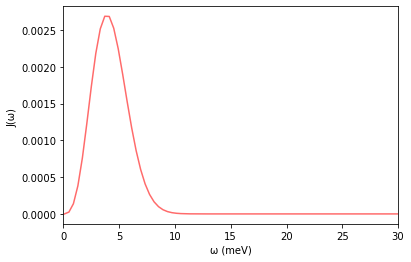

In [4]:
import numpy as np
import matplotlib.pyplot as plt

ω = np.linspace(0.0001,0.08,200)/27.2114
# spectral density
def JLA(ω):
    ps = 41341.374575751
    a = 1.41586e+12
    α  =  (2.4 * ps**2.0)
    r  =  α /a
    ωb = 0.002255/27.2114
    #* 4.0 * np.pi **2.0 
    return  α * (ω ** 3.0) * np.exp(-ω**2.0/(2.0 * ωb**2.0))
 
fig = plt.figure()
splt = fig.add_subplot(111)
splt.set_ylabel('J(ω) ')
splt.set_xlabel('ω (meV)')
 
splt.plot(ω*27.2114 * 1000, JLA(ω), c="#ff6b6b")
plt.xlim(0,30)

print ( "The reorganization energy, λ (numerical) is", (1/np.pi)* np.sum(JLA(ω)/ω)* (ω[1]-ω[0]) * 27.2114 * 1000, "meV")


Total Reorganization Energy = 25.341305741224076 meV


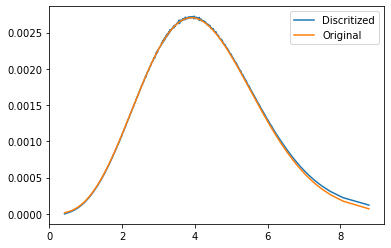

In [9]:
# Get LA phonons
ωj , cj = discretize1(300, JLA, np.linspace(0.00001,0.07,500000)/27.2114)  
λs =  (np.sum( (1/2) * (cj**2.0) / (ωj**2) * 27.2114) )
print(f"Total Reorganization Energy = {λs * 1000} meV")

dωj = ωj - np.roll(ωj,1) # Note that each mode is spread over dωj
plt.plot(ωj * 27.2114 * 1000, np.pi/2 *  cj**2/ωj/dωj, label = 'Discritized')
plt.plot(ωj * 27.2114 * 1000,  JLA(ωj), label = 'Original')
plt.legend()

In [8]:
np.savetxt("bath.txt", np.c_[ωj , cj])

# Code to Numerically Discretize : Version 1 

Note that here we use analytically availabale $F_\omega(\omega)$.  

In [16]:
def discretize2(N, F, ωmax = 0.5/27.2114):
    ω = np.linspace(0.00000001, ωmax, N * 1000)
    dω = ω[1] - ω[0]
    Fω = F(ω)
    λs = Fω[-1] 

    ωj = np.zeros((N))
    cj = np.zeros((N))
    for i in range(N):
        j = i+1
        ωj[i] = ω[np.argmin(np.abs(Fω - ((j-0.5)/N) *  λs))] 
        cj[i] =  ωj[i] * (2 * λs/ N)**0.5 
    return ωj, cj

# Example 2
## Debye Spectral Density

Here we consider a debye spectral density,

$$
\begin{align}
J(\omega) = \frac{2\lambda \gamma \omega}{(\omega^2+\gamma^2)}
\end{align}
$$


For this we  can analytically obtain $ \begin{align}
 {1\over \pi}\int_{0}^{\omega_j} {J(\omega) \over \omega }d \omega \equiv F_{\omega} (\omega_j) \\
 = {2 \lambda \gamma \over \pi} \int_{0}^{\omega_j} \frac{1}{\omega^2 + \gamma^2} d\omega = {2 \lambda \over \pi }\tan^{-1} (\omega_j/\gamma) 
 \end{align}$

Note that,
$ \begin{align}
 \lim_{\omega_j \rightarrow \infty} {1\over \pi}\int_{0}^{\omega_j} {J(\omega) \over \omega }d \omega  \\
 = \lim_{\omega_j \rightarrow \infty}  {2 \lambda \over \pi }\tan^{-1} (\omega_j/\gamma) = \lambda 
\end{align}$

The reorganization energy, λ (numerical) is 0.005470501336392289 meV


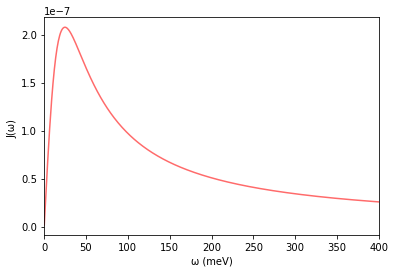

In [14]:
def JD(ω):
    𝛾  = 0.0009113 # 200 cm-1
    ωb = 0.004556335 
    ɑ  =  0.1 * ωb
    λ  = ɑ * 𝛾 /2 
    return 2*λ*𝛾*ω/(ω**2+𝛾**2)


ω = np.linspace(0.0001,0.4,500)/27.2114
fig = plt.figure()
splt = fig.add_subplot(111)
splt.set_ylabel('J(ω) ')
splt.set_xlabel('ω (meV)')
 
splt.plot(ω*27.2114 * 1000, JD(ω), c="#ff6b6b")
plt.xlim(0,400)

print ( "The reorganization energy, λ (numerical) is", (1/np.pi)* np.sum(JD(ω)/ω)* (ω[1]-ω[0]) * 27.2114 * 1000, "meV")


In [15]:
# (1/π) * ∫J(ω)/ω
def FD(ω):
    𝛾  = 0.0009113 # 200 cm-1
    ωb = 0.004556335 
    ɑ  =  0.1 * ωb
    λ  = ɑ * 𝛾 /2 
    return (2 * λ / π) * np.arctan(ω/𝛾)

Total Reorganization Energy = 0.0055007859463044395 meV


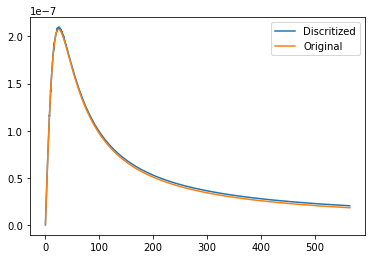

In [17]:
ωj , cj = discretize2(300, FD, 0.6/27.2114)  
λs =  (np.sum( (1/2) * (cj**2.0) / (ωj**2) * 27.2114) )
print(f"Total Reorganization Energy = {λs * 1000} meV")

dωj = ωj - np.roll(ωj,1) # Note that each mode is spread over dωj
plt.plot(ωj * 27.2114 * 1000, np.pi/2 *  cj**2/ωj/dωj, label = 'Discritized')
plt.plot(ωj * 27.2114 * 1000,  JD(ωj), label = 'Original')
plt.legend()

In [18]:
np.savetxt("bath.txt", np.c_[ωj , cj])